In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T

import os
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.preprocessing import MinMaxScaler

from collections import OrderedDict

In [2]:
# Template Parameters
input_PATH = "Data/Geoid/1k/input.npy"
output_PATH = "Data/Geoid/1k/output.npy"

hidden_layers_list = [10]
act_function = "ReLU"
loss_type = "MSELoss"
n_epoch = 100
batch_size = 16
lr = 0.0001
accurate_loss_baseline = 0.02
output_scaler = "MinMax"
model_name = "template"

In [3]:
# Parameters
input_PATH = "Data/Geoid/new_results_1k_zero/zero_1k-inv.npy"
output_PATH = "Data/Geoid/new_results_1k_zero/zero_1k-geoid.npy"
hidden_layers_list = [200, 160, 120, 80]
act_function = "ReLU"
loss_type = "MSELoss"
n_epoch = 200
batch_size = 16
lr = 0.0001
accurate_loss_baseline = 0.01
output_scaler = "MinMax"
model_name = "1k_zero"


In [4]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print("Current device is ",device)

# Fit the MinMaxScalar for output data if it's specified
if output_scaler == "MinMax":
    output_for_Scalar = np.load(output_PATH)
    scaler = MinMaxScaler()
    scaler.fit(output_for_Scalar)
    print("Fit the output range to [0,1] using MinMaxscaler")
    
# make results determinstic
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
    
    # Customised Dataset class
class KMNIST(Dataset):
    
    def __init__(self, input_path, output_path):
        # Load the input and output
        input_data = np.load(input_path)
        output_data = np.load(output_path)
        
        if output_scaler == "MinMax":
            output_data = scaler.transform(np.load(output_path))
        
        self.input = input_data
        self.output = output_data
        
    def __len__(self):
        return len(self.input)

    def __getitem__(self, index):
        input_item = self.input[index]
        output_item = self.output[index]
        
        return input_item, output_item
        
testingAndValidation_split = 0.2
validation_split = 0.1

# Load the input and output as a complete dataset

geoid_dataset = KMNIST(
    input_PATH,
    output_PATH,
)


# Creating data indices for training, testing and validation splits
# Reference: https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets
geoid_dataset_size = len(geoid_dataset)
geoid_indices = list(range(geoid_dataset_size))

geoid_training_testing_split = int(np.floor(testingAndValidation_split * geoid_dataset_size))
geoid_testing_validation_split = int(np.floor(validation_split * geoid_dataset_size))

np.random.shuffle(geoid_indices)
geoid_train_indices, geoid_val_indices ,geoid_test_indices = geoid_indices[geoid_training_testing_split:], geoid_indices[:geoid_testing_validation_split], geoid_indices[geoid_testing_validation_split:geoid_training_testing_split] 

# Creating data samplers
geoid_train_sampler = SubsetRandomSampler(geoid_train_indices)
geoid_test_sampler = SubsetRandomSampler(geoid_test_indices)
geoid_valid_sampler = SubsetRandomSampler(geoid_val_indices)

geoid_train_loader = DataLoader(
     dataset=geoid_dataset,
    batch_size = batch_size,
    sampler=geoid_train_sampler,
)

geoid_test_loader = DataLoader(
    dataset=geoid_dataset,
    batch_size = batch_size,
    sampler=geoid_test_sampler,
)

geoid_validation_loader = DataLoader(
    dataset=geoid_dataset,
    batch_size = batch_size,
    sampler=geoid_valid_sampler,
)
    
print("Dataset Loaded!\n")
    

Current device is  cpu
Fit the output range to [0,1] using MinMaxscaler
Dataset Loaded!



In [5]:
# Training Function
def train(model, train_loader, val_loader, device, optimizer, n_epoch):
    
    criterion = nn.MSELoss()
    if loss_type == 'L1Loss':
        criterion = nn.L1Loss()
    
    minimum_validation_loss = 10000000
    best_model_index = -1
    
    running_loss_list = []
    validation_loss_list = []

    # n_epoch times of iterations
    for epoch in range(n_epoch):

        running_loss = 0.0

        model.train()
        
        for data in train_loader:
            # get a batch of inputs and labels
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = inputs.to(torch.float32)

            # zero the parameter gradients
            optimizer.zero_grad(set_to_none=True)

            # Get output features, calculate loss and optimize
            outputs = model(inputs)
            loss = criterion(outputs.float(), labels.float())
            
            loss.backward()
            optimizer.step()

            # Add to the total training loss
            running_loss += loss.item()

        # print some statistics
        if epoch+1 == n_epoch // 4:
            print("25% of the training has finished")
                
        if epoch+1 == n_epoch // 2:
            print("50% of the training has finished")
                
        if epoch+1 == 3 * n_epoch // 4:
            print("75% of the training has finished")
            
        #print("Current training loss is ",running_loss)
        running_loss_list.append(running_loss)
        running_loss = 0.0

        # Valiadation
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            valid_loss = 0.0
            for data in val_loader:
                inputs, labels = data[0].to(device), data[1].to(device)
                inputs = inputs.to(torch.float32)
                
                # Get output features and calculate loss
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # If the loss value is less than accurate loss baseline, we consider it being accurate
                for j in range(len(labels)):
                    single_loss = criterion(outputs[j], labels[j])
                    if single_loss.item() <= accurate_loss_baseline:
                        correct += 1
                    total += 1
    
                # Add to the validation loss
                valid_loss += loss.item()

            # Calculate valiadation accuracy and print Validation statistics
            #print("Validation loss for this epoch is",valid_loss)
            #print("Validation Accuracy for this epoch is", 100*correct//total)
            validation_loss_list.append(valid_loss)

        # Update the statistics for the best model
        if valid_loss <= minimum_validation_loss:
            minimum_validation_loss = valid_loss

            # Store the best models for each model in the list
        
            PATH = '1D_results_notebook/{}_best.pth'.format(model_name)

            torch.save(model.state_dict(), PATH)
            #print("This model is now saved to Path:",PATH)
            
            best_model_index = epoch
            
        #print()
    
    # Training finished, print the statistics for the best model
    print('Training Finished')
    print("Best model has a validation loss of {} and it's in epoch {}".format(minimum_validation_loss, best_model_index+1))
    
    # Plot the Training loss and validation loss during training
    plt.figure(figsize=(12, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(running_loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss in each epoch')

    plt.subplot(2, 1, 2)
    plt.plot(validation_loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss in each epoch')
    
    plt.subplots_adjust(hspace=1)
    
    plt.show()
        
# Testing Function
def test(model, test_loader, device):

    # Load the model from the input model_path  
    #model.load_state_dict(torch.load(model_path))

    correct = 0
    total = 0
    
    threshold_list = [1e-2,1e-3,1e-4,1e-5]
    threshold_correct_list = [0,0,0,0]
        
    criterion = nn.MSELoss()
    if loss_type == 'L1Loss':
        criterion = nn.L1Loss()
            
    total_loss = 0.0
        
    
    best_worst_error_list = [1000000, 0]
    best_worst_input_list = [0, 0]
    best_worst_output_list = [0, 0]
    best_worst_predicted_list = [0, 0]
    
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = inputs.to(torch.float32)
                
            # Get output features and calculate loss
            outputs = model(inputs)
            loss = criterion(outputs, labels)
                
            # If the loss value is less than accurate loss baseline, we consider it being accurate
            for j in range(len(labels)):
                single_loss = criterion(outputs[j], labels[j])
                
                if single_loss.item() <= accurate_loss_baseline:
                    correct += 1
                    
                for t_index in range(len(threshold_list)):
                    if single_loss.item() <= threshold_list[t_index]:
                        threshold_correct_list[t_index] += 1
                    
                total += 1
                
                # Record worst error
                if single_loss.item() > best_worst_error_list[1]:
                    best_worst_error_list[1] = single_loss.item()
                    best_worst_input_list[1] = inputs[j]
                    best_worst_output_list[1] = labels[j]
                    best_worst_predicted_list[1] = outputs[j]
                    
                # Record best error
                if single_loss.item() < best_worst_error_list[0]:
                    best_worst_error_list[0] = single_loss.item()
                    best_worst_input_list[0] = inputs[j]
                    best_worst_output_list[0] = labels[j]
                    best_worst_predicted_list[0] = outputs[j]
                    

            # Add to the validation loss
            total_loss += loss.item()

    # Calculate the overall accuracy and return the accuracy and test loss
    print("Total loss for the model is {}, and accuracy using given threshold is {}%".format(total_loss,100*correct//total))
    
    # Calculate accuracy using pre-defined loss threshold
    for i in range(len(threshold_list)):
        print("When the loss threshold is set to {}, accuracy is {}%".format(threshold_list[i],100*threshold_correct_list[i]//total))
    
    # Draw some plots for the best and the worst error
    print("Best model has a error of ", best_worst_error_list[0])
    
    plt.figure(figsize=(12, 6))
        
    plt.subplot(1, 2, 1)
    
    plt.title("Best case input")
    plt.plot(best_worst_input_list[0].detach().numpy())

        
    plt.subplot(1, 2, 2)
    
    plt.title("Best case plot")
    
    if output_scaler == "MinMax":
        plt.plot(scaler.inverse_transform([best_worst_output_list[0].detach().numpy()])[0], label='Data Output')
        plt.plot(scaler.inverse_transform([best_worst_predicted_list[0].detach().numpy()])[0], label='Predicted Output')
    else:
        plt.plot(best_worst_output_list[0].detach().numpy(), label='Data Output')
        plt.plot(best_worst_predicted_list[0].detach().numpy(), label='Predicted Output')
        
    plt.legend()
    
    plt.show()
    
    
    print("Worst model has a error of ", best_worst_error_list[1])
    
    plt.figure(figsize=(12, 6))
        
    plt.subplot(1, 2, 1)
    
    plt.title("Worst case input")
    plt.plot(best_worst_input_list[1].detach().numpy())

    plt.subplot(1, 2, 2)
    
    plt.title("Worst case plot")
    
    if output_scaler == "MinMax":
        plt.plot(scaler.inverse_transform([best_worst_output_list[1].detach().numpy()])[0], label='Data Output')
        plt.plot(scaler.inverse_transform([best_worst_predicted_list[1].detach().numpy()])[0], label='Predicted Output')
    else:
        plt.plot(best_worst_output_list[1].detach().numpy(), label='Data Output')
        plt.plot(best_worst_predicted_list[1].detach().numpy(), label='Predicted Output')
        
    plt.legend()

    plt.show()
    
    #return 100*correct//total, total_loss

In [6]:
# Initialize Model and Optimizer
neurons_list = [len(geoid_dataset.input[0])] + hidden_layers_list + [len(geoid_dataset.output[0])]
layers_od = OrderedDict()
for i in range(len(neurons_list)-1):
    fc_name = 'fc' + str(i+1)
    layers_od[fc_name] = nn.Linear(neurons_list[i], neurons_list[i+1])
        
    if act_function == "ReLU" and i != len(neurons_list)-2:
        tanh_name = 'relu' + str(i+1)
        layers_od[tanh_name] = nn.ReLU()
            
model = nn.Sequential(layers_od).to(device)
print(model)
print()

Sequential(
  (fc1): Linear(in_features=257, out_features=200, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=200, out_features=160, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=160, out_features=120, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=120, out_features=80, bias=True)
  (relu4): ReLU()
  (fc5): Linear(in_features=80, out_features=60, bias=True)
)



In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Training Start!
25% of the training has finished
50% of the training has finished
75% of the training has finished
Training Finished
Best model has a validation loss of 0.0006654232705257907 and it's in epoch 185


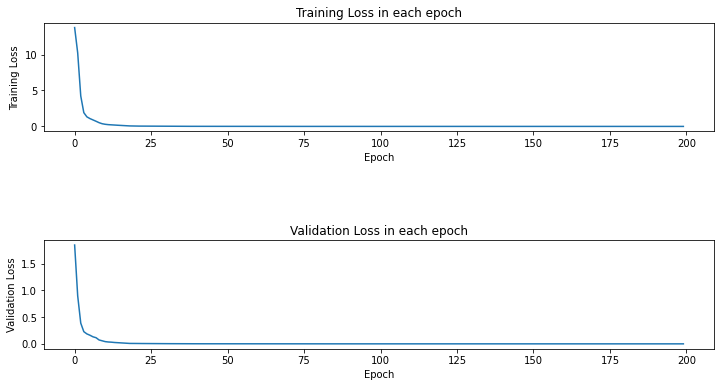

In [8]:
# Training
print("Training Start!")
train(model, geoid_train_loader, geoid_validation_loader, device, optimizer, n_epoch)

Testing for the training set:
Total loss for the model is 0.0006523649456915537, and accuracy using given threshold is 100%
When the loss threshold is set to 0.01, accuracy is 100%
When the loss threshold is set to 0.001, accuracy is 100%
When the loss threshold is set to 0.0001, accuracy is 100%
When the loss threshold is set to 1e-05, accuracy is 52%
Best model has a error of  7.804676050842155e-07


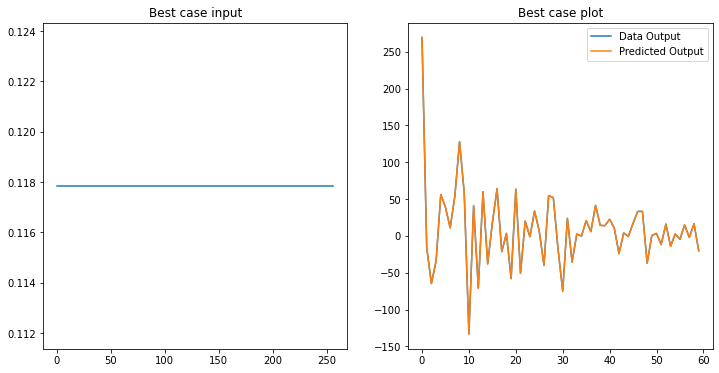

Worst model has a error of  9.761356123353227e-05


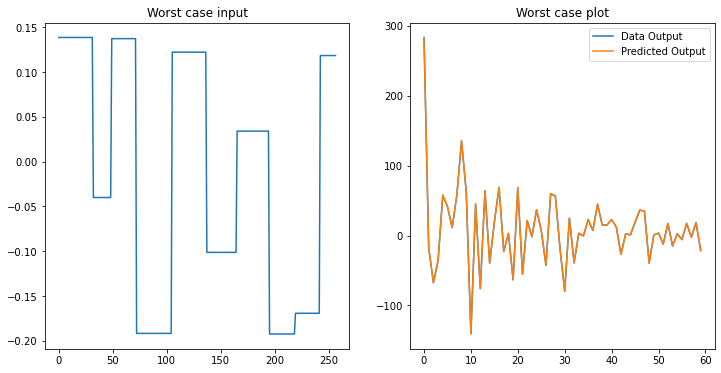

In [9]:
# Testing with training set and testing set
print("Testing for the training set:")
test(model, geoid_train_loader, device)

Testing for the testing set:
Total loss for the model is 0.0005452869412227539, and accuracy using given threshold is 100%
When the loss threshold is set to 0.01, accuracy is 100%
When the loss threshold is set to 0.001, accuracy is 100%
When the loss threshold is set to 0.0001, accuracy is 75%
When the loss threshold is set to 1e-05, accuracy is 39%
Best model has a error of  7.807725056434319e-07


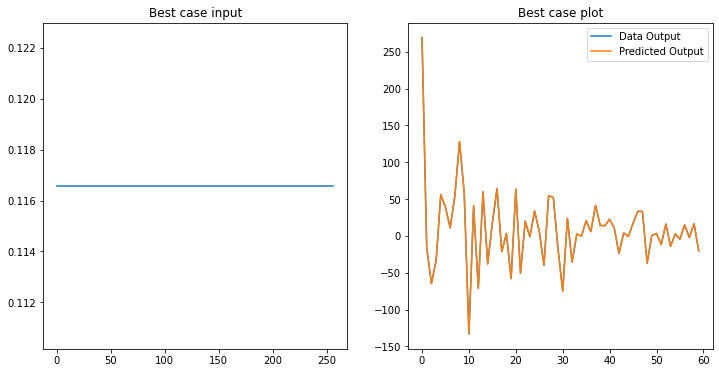

Worst model has a error of  0.000898992903182189


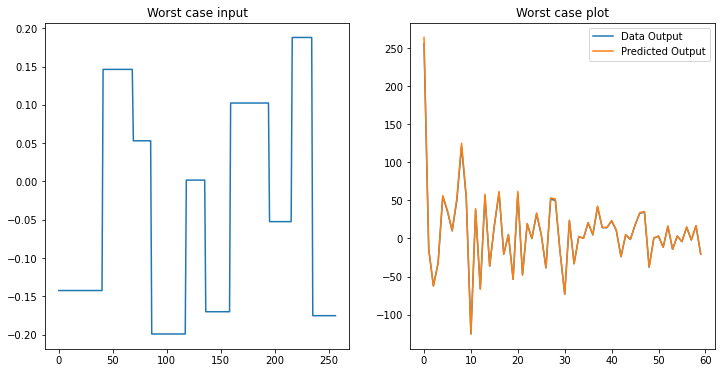

In [10]:
print("Testing for the testing set:")
test(model, geoid_test_loader, device)